# Fast Gradient Sign Attack:

`General goal`: Add the least amount of pertubations to the input that causes desired misclassification.

`Assumptions on attacker's knowledge`: 

1.   White-Box: Attacker has full knowledge and access to the model, architecture, inputs, outputs and weights.
2.   Black-Box: Attacher has knowledge only about the inputs and outputs of the model and no information about the underlynig model architecture or weights.

`Goals`:
1. misclassification: Attacker only wants the output classification to be wrong and does not care about what the new classification is.
1. Source/Target misclassification: pertubations to the input that belongs to a specific source class so that it is classified as a specific target class.

FGSM : `White-box` attack with the goal of `misclassification`.

`Fast Gradient Sign Attack`: Use gradient of the loss w.r.t input data, then adjust the inputs to maximize the loss



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#create data transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

#check and set GPU/CPU based on availability
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

# download and load FashionMNIST
train_data  = datasets.FashionMNIST(root="./data", download=True, train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

test_data  = datasets.FashionMNIST(root="./data", download=True, train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
X_, _ = next(iter(train_dataloader))
X_.shape

torch.Size([64, 1, 28, 28])

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


In [ ]:
eps = [0, 0.05, .1,.15, .2, .25, .3]

In [ ]:
#Crate CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #12, 12, 10
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #4, 4, 20
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
#Train Model
model = CNN().to(device)


learning_rate = 1e-3
batch_size = 64
epochs = 5

train_loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
epochs = 10
model.train()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, train_loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307661  [   64/60000]
loss: 0.847931  [32064/60000]
Epoch 2
-------------------------------
loss: 0.506442  [   64/60000]
loss: 0.451394  [32064/60000]
Epoch 3
-------------------------------
loss: 0.773173  [   64/60000]
loss: 0.579829  [32064/60000]
Epoch 4
-------------------------------
loss: 0.506007  [   64/60000]
loss: 0.439675  [32064/60000]
Epoch 5
-------------------------------
loss: 0.614095  [   64/60000]
loss: 0.529079  [32064/60000]
Epoch 6
-------------------------------
loss: 0.563377  [   64/60000]
loss: 0.790615  [32064/60000]
Epoch 7
-------------------------------
loss: 0.387124  [   64/60000]
loss: 0.530624  [32064/60000]
Epoch 8
-------------------------------
loss: 0.501370  [   64/60000]
loss: 0.511477  [32064/60000]
Epoch 9
-------------------------------
loss: 0.331306  [   64/60000]
loss: 0.579453  [32064/60000]
Epoch 10
-------------------------------
loss: 0.251560  [   64/60000]
loss: 0.573996  [32064/60000]

In [ ]:
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
#FGSM attack

def FGSM_attack(image, eps, data_grad):
  sign_ = data_grad.sign()
  noise_img = image + eps*(sign_)
  noise_img = torch.clamp(noise_img, 0, 1)
  return noise_img


In [ ]:
def test(model, device, test_dataloader, eps):

  correct =0
  adv_examples = []

  for data, label in test_dataloader:

    data, label = data.to(device), label.to(device)

    data.requires_grad = True
    output = model(data)
    initial_pred = output.max(1, keepdim=True)[1] #index of max log-sftmx prob

    if initial_pred.item()!=label.item(): continue
    loss = F.nll_loss(output, label)

    model.zero_grad()
    loss.backward()

    data_grad = data.grad.data

    noisy_image = FGSM_attack(data, eps, data_grad)
    new_output = model(noisy_image)

    #check if this was a successful adversial data
    new_pred = new_output.max(1, keepdim=True)[1]
    if new_pred.item() == label.item():
      correct+=1
      # Special case for saving 0 epsilon examples
      if (eps == 0) and (len(adv_examples) < 5):
                adv_ex = noisy_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (initial_pred.item(), new_pred.item(), adv_ex) )

    else:
      if len(adv_examples) < 5:
          adv_ex = noisy_image.squeeze().detach().cpu().numpy()
          adv_examples.append( (initial_pred.item(), new_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_dataloader))
  print(f"Epsilon: {eps}\tTest Accuracy = {correct} / {len(test_dataloader)} = {final_acc}")
  return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for ep in eps:
    acc, ex = test(model, device, test_dataloader, ep)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8625 / 10000 = 0.8625
Epsilon: 0.05	Test Accuracy = 3497 / 10000 = 0.3497
Epsilon: 0.1	Test Accuracy = 1783 / 10000 = 0.1783
Epsilon: 0.15	Test Accuracy = 1001 / 10000 = 0.1001
Epsilon: 0.2	Test Accuracy = 534 / 10000 = 0.0534
Epsilon: 0.25	Test Accuracy = 234 / 10000 = 0.0234
Epsilon: 0.3	Test Accuracy = 79 / 10000 = 0.0079


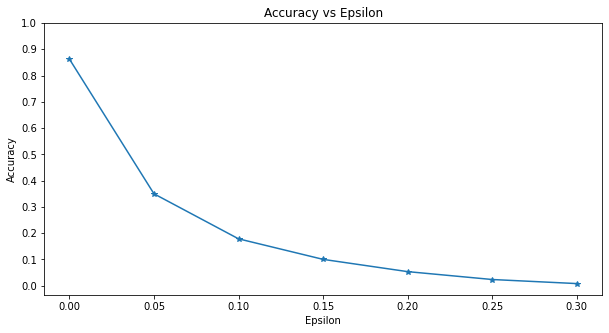

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(eps, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

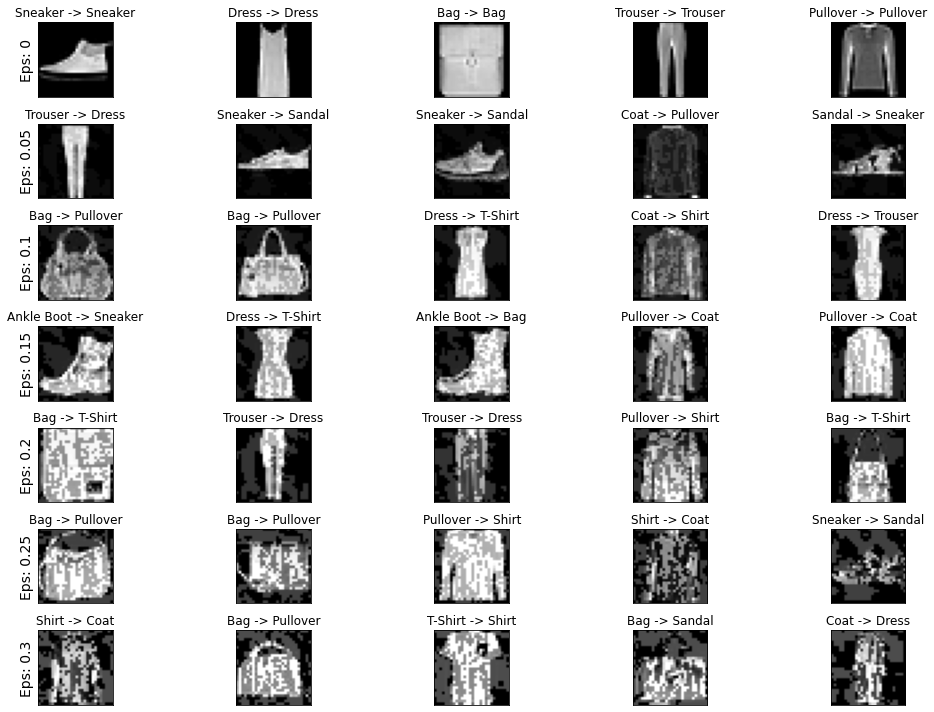

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(15,10))
for i in range(len(eps)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(eps),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(eps[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{labels_map[orig]} -> {labels_map[adv]}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()